In [1]:
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy import signal
from timeit import default_timer as timer

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import gaussian_filter

import window_function_3D
import phase_corr_make_universe_3D as uni
import pspec_3D 


%load_ext autoreload
%autoreload 2

# Testing 3D make Universe

In [2]:
npix_row,npix_col, npix_aisle = 50,50,50

Lx = 325.5
theta_x = Lx/(cosmo.comoving_distance(8).value)

Ly = 325.5
theta_y = Ly/(cosmo.comoving_distance(8).value)

Lz = 325.49848672680474
nu = Lz/(((sc.c*((1+8)**2))/(cosmo.H0.value*1000*(1.24e9)*cosmo.efunc(8))))

nbins = 30

def ps(x):
    mu, sigma = 0.2,0.04
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

In [3]:
print(theta_x, theta_y, nu)

print(nu/(1e6))

0.035480834511626834 0.035480834511626834 16702450.70422538
16.70245070422538


Text(0.5, 0, 'k [Mpc$^{-1}$]')

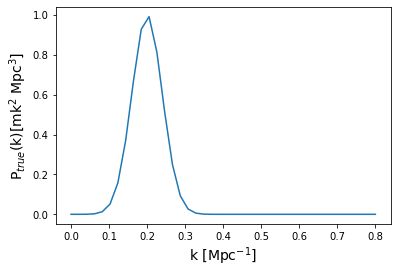

In [4]:
x = np.linspace(0,0.8,40)
plt.plot(x,ps(x))#*((x**3)/(2*np.pi)**2))
plt.ylabel('P$_{true}$(k)[mk$^2$ Mpc$^3$]', fontsize = 14)
plt.xlabel('k [Mpc$^{-1}$]', fontsize = 14)

In [5]:
uni_3d = uni.universe(ps,npix_row,npix_col,npix_aisle, Ly,Lx,Lz,30,0,1,8)
uni_3d.make_universe()

325.5 325.5 325.49848672680474


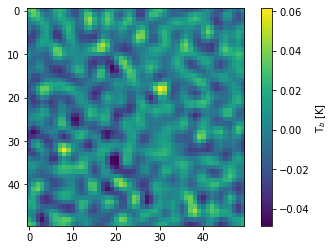

In [6]:
plt.imshow(uni_3d.universe[:,:,2])#redshift evolution slice (top view) 
plt.colorbar(label = 'T$_b$ [K]')

In [7]:
def gauss(x,y,sigma_x,sigma_y,mu_x,mu_y):
    return np.exp(-((((x-mu_x)**2)/(2*(sigma_x**2))) + (((y-mu_y)**2)/(2*(sigma_y**2)))))#* (1/(2*np.pi*sigma_x*sigma_y))

x = np.arange(-25,25,1)
y = np.arange(-25,25,1)
xx, yy = np.meshgrid(x,y, sparse = True)

observed_uni = np.zeros_like(uni_3d.universe)
gaussian = np.reshape(gauss(xx,yy,1.5,1.5,0,0),(50,50))
gaussian/=gaussian.sum()  #why do you need to noramlize this gaussian like this??



filtered = gaussian_filter(uni_3d.universe[:,:,2], sigma=1.5)





for i in range(npix_aisle):
    sky_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(uni_3d.universe[:,:,i])))
    gauss_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaussian)))
    
    product = sky_fft*gauss_fft

    new_sky = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(product)))
    observed_uni[:,:,i] = np.real(new_sky)
#      observed_uni[:,:,i] = gaussian_filter(uni_3d.universe[:,:,i], sigma=1.5)



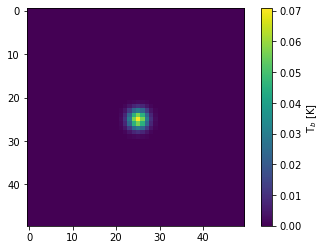

In [8]:
plt.imshow(gaussian)#redshift evolution slice (top view) 
plt.colorbar(label = 'T$_b$ [K]')

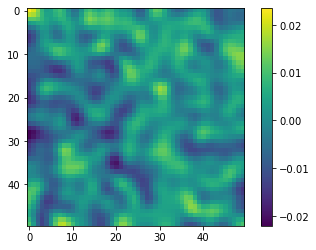

In [9]:

plt.imshow(filtered)
plt.colorbar()

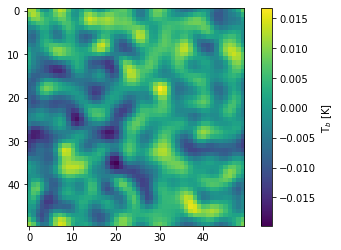

In [10]:
plt.imshow(observed_uni[:,:,2])#redshift evolution slice (top view) 
plt.colorbar(label = 'T$_b$ [K]')

In [12]:
freq_mid = 1420/(1+8)
pm_freq = 19.127/2

freqs = np.linspace(freq_mid-pm_freq, freq_mid+pm_freq,51)

pspec= pspec_3D.Power_Spectrum(uni_3d.universe, theta_x, theta_y,freqs*(1e6),1420*(1e6),30,60)
pspec_obs= pspec_3D.Power_Spectrum(observed_uni, theta_x, theta_y,freqs*(1e6),1420*(1e6),30,60)

In [13]:
pspec.compute_2D_pspec()
pspec_obs.compute_2D_pspec()

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_5077/3878284194.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, edgecolors='w', linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

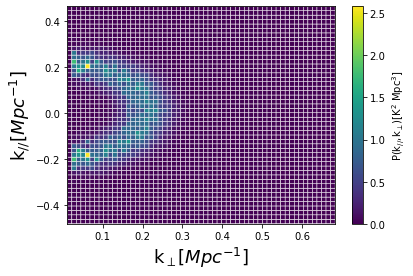

In [14]:
im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)


# plt.xscale('log')
# plt.yscale('log')

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_5077/1965702007.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec_obs.pspec_2D)#, edgecolors='w', linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

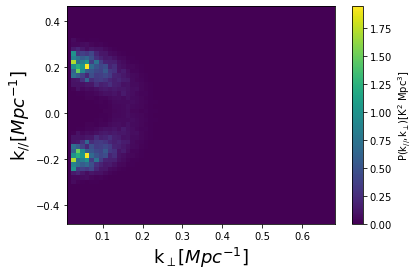

In [16]:
im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec_obs.pspec_2D)#, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)


In [17]:
pspec.compute_1d_from_2d()
pspec_obs.compute_1d_from_2d()

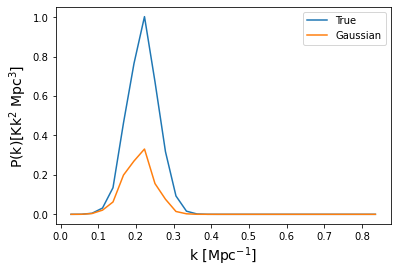

In [18]:
plt.plot(pspec.k_modes, pspec.pspec_1D, label = "True")
plt.plot(pspec.k_modes,pspec_obs.pspec_1D, label = "Gaussian")#mode conversions are fine. 
# plt.axvline(x = 0.2)
# plt.ylim(0,2.6)
plt.ylabel('P(k)[Kk$^2$ Mpc$^3$]', fontsize = 14)
plt.xlabel('k [Mpc$^{-1}$]', fontsize = 14)
plt.legend()

In [19]:
max(pspec.pspec_1D), max(pspec_obs.pspec_1D)

(1.002718163294646, 0.33122559511330674)

In [20]:
pspec.compute_1D_pspec() #275.894451 from make universe

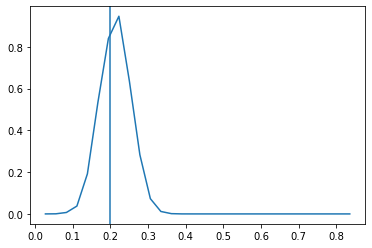

In [21]:
plt.plot(pspec.k_modes,pspec.ps_1D) #mode conversions are fine. 
plt.axvline(x = 0.2)# having an amplitude problemo!! need to verify the units on pspec_data and volume3D

[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  0.13512289  0.15442616  0.17372943  0.1930327
  0.21233597  0.23163924  0.25094252  0.27024579  0.28954906  0.30885233
  0.3281556   0.34745887  0.36676214  0.38606541  0.40536868  0.42467195
  0.44397522  0.46327849]
[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  

[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  0.13512289  0.15442616  0.17372943  0.1930327
  0.21233597  0.23163924  0.25094252  0.27024579  0.28954906  0.30885233
  0.3281556   0.34745887  0.36676214  0.38606541  0.40536868  0.42467195
  0.44397522  0.46327849]
[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  

[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  0.13512289  0.15442616  0.17372943  0.1930327
  0.21233597  0.23163924  0.25094252  0.27024579  0.28954906  0.30885233
  0.3281556   0.34745887  0.36676214  0.38606541  0.40536868  0.42467195
  0.44397522  0.46327849]
[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  

[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  0.13512289  0.15442616  0.17372943  0.1930327
  0.21233597  0.23163924  0.25094252  0.27024579  0.28954906  0.30885233
  0.3281556   0.34745887  0.36676214  0.38606541  0.40536868  0.42467195
  0.44397522  0.46327849]
[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  

[-0.48258176 -0.46327849 -0.44397522 -0.42467195 -0.40536868 -0.38606541
 -0.36676214 -0.34745887 -0.3281556  -0.30885233 -0.28954906 -0.27024579
 -0.25094252 -0.23163924 -0.21233597 -0.1930327  -0.17372943 -0.15442616
 -0.13512289 -0.11581962 -0.09651635 -0.07721308 -0.05790981 -0.03860654
 -0.01930327  0.          0.01930327  0.03860654  0.05790981  0.07721308
  0.09651635  0.11581962  0.13512289  0.15442616  0.17372943  0.1930327
  0.21233597  0.23163924  0.25094252  0.27024579  0.28954906  0.30885233
  0.3281556   0.34745887  0.36676214  0.38606541  0.40536868  0.42467195
  0.44397522  0.46327849]


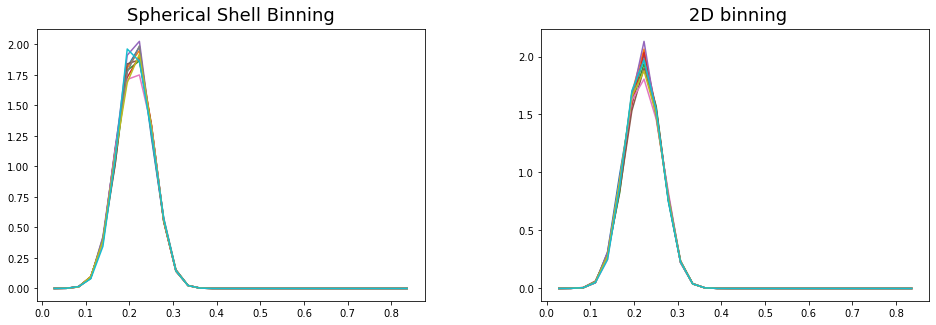

In [20]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 2,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax1.set_title('Spherical Shell Binning', fontsize = 18, y = 1.01)
ax2.set_title(' 2D binning', fontsize = 18, y = 1.01 )

nreals = 10
for i in range(nreals):
    uni_3d.make_universe() # make universe
    pspec = pspec_3D.Power_Spectrum(uni_3d.universe, theta_x, theta_y,freqs*(1e6),1420*(1e6),30) #initialize spectrum
    pspec.compute_1D_pspec() 
    pspec.compute_1d_from_2d()

    ax1.plot(pspec.k_modes,pspec.ps_1D)

    ax2.plot(pspec.k_modes,pspec.pspec_1D)
    
    

# Testing 3D window

as a first test, just make sure that M matrix of ones gives back input spectrum

### Identity Window Function

In [22]:
M= []

for i in range(npix_aisle):
    m = np.diag(np.diag(np.ones((50*50,50*50))))
    M.append(m)
    
M = np.asarray(M).T

### Gaussian Window Function 

In [23]:
def gauss(x,y,sigma_x,sigma_y,mu_x,mu_y):
    return np.exp(-((((x-mu_x)**2)/(2*(sigma_x**2))) + (((y-mu_y)**2)/(2*(sigma_y**2)))))#* (1/(2*np.pi*sigma_x*sigma_y))

x = np.arange(-25,25,1)
y = np.arange(-25,25,1)
xx, yy = np.meshgrid(x,y, sparse = True)


gaussian = np.reshape(gauss(xx,yy,1.5,1.5,0,0),(50,50)) 
M_gauss = np.zeros((2500,2500,50))
for i in range(npix_aisle):
    gaussian = np.reshape(gauss(xx,yy,1.5,1.5,0,0),(50,50))
    gaussian /=gaussian.sum()
    gaussian = gaussian.reshape(2500,)
    diag_g = np.diag(gaussian)
    M_gauss[:,:,i] = diag_g




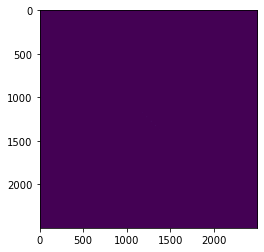

In [24]:
plt.imshow(M_gauss[:,:,2],interpolation= None)

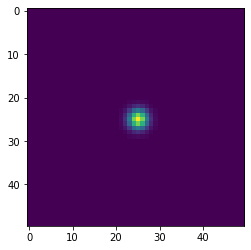

In [25]:
plt.imshow(np.reshape(np.diag(M_gauss[:,:,2]),(50,50)))

In [26]:
rest_freq = 1420
window = window_function_3D.Window_Function(M_gauss, npix_row, npix_col,theta_x,theta_y,freqs*(1e6),rest_freq*(1e6), nbins)



In [46]:
window.Lx, window.Ly,window.Lz, window.z_mid

(325.50000000000006, 325.50000000000006, 325.4979894550992, 8.000000000000002)

In [32]:
kmodes_true = np.fft.fftshift(pspec.k_par),pspec.k_perp_bin
kmodes_obs = np.fft.fftshift(pspec.k_par)

In [33]:
print(kmodes_true)

(array([-0.48258176, -0.46327849, -0.44397522, -0.42467195, -0.40536868,
       -0.38606541, -0.36676214, -0.34745887, -0.3281556 , -0.30885233,
       -0.28954906, -0.27024579, -0.25094252, -0.23163924, -0.21233597,
       -0.1930327 , -0.17372943, -0.15442616, -0.13512289, -0.11581962,
       -0.09651635, -0.07721308, -0.05790981, -0.03860654, -0.01930327,
        0.        ,  0.01930327,  0.03860654,  0.05790981,  0.07721308,
        0.09651635,  0.11581962,  0.13512289,  0.15442616,  0.17372943,
        0.1930327 ,  0.21233597,  0.23163924,  0.25094252,  0.27024579,
        0.28954906,  0.30885233,  0.3281556 ,  0.34745887,  0.36676214,
        0.38606541,  0.40536868,  0.42467195,  0.44397522,  0.46327849]), array([0.01137451, 0.02274902, 0.03412352, 0.04549803, 0.05687254,
       0.06824705, 0.07962156, 0.09099607, 0.10237057, 0.11374508,
       0.12511959, 0.1364941 , 0.14786861, 0.15924312, 0.17061762,
       0.18199213, 0.19336664, 0.20474115, 0.21611566, 0.22749017,
       0.

In [36]:
window.compute_2D_pspec_estimate(pspec.pspec_2D,kmodes_true,kmodes_obs)

perp FFT done
parallel FFT done
square done
sorted in k_perp


0.9
[1.38258176 1.36327849 1.34397522 1.32467195 1.30536868 1.28606541
 1.26676214 1.24745887 1.2281556  1.20885233 1.18954906 1.17024579
 1.15094252 1.13163924 1.11233597 1.0930327  1.07372943 1.05442616
 1.03512289 1.01581962 0.99651635 0.97721308 0.95790981 0.93860654
 0.91930327 0.9        0.88069673 0.86139346 0.84209019 0.82278692
 0.80348365 0.78418038 0.76487711 0.74557384 0.72627057 0.7069673
 0.68766403 0.66836076 0.64905748 0.62975421 0.61045094 0.59114767
 0.5718444  0.55254113 0.53323786 0.51393459 0.49463132 0.47532805
 0.45602478 0.43672151]


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

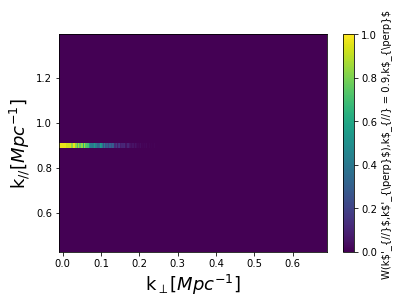

In [43]:
window.one_window()

plt.pcolor(window.k_perp_sorted,window.k_prime_sorted, window.window_to_plot.T,shading='auto')
plt.colorbar(label = 'W(k$\'_{//}$,k$\'_{\perp}$),k$_{//} = 0.9,k$_{\perp}$ ') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
# plt.title('Window Estimated Pspec')

Text(0.5, 1.0, 'Window Estimated Pspec')

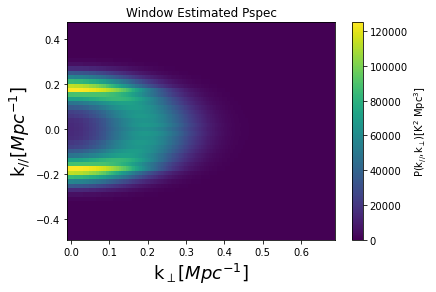

In [53]:
plt.pcolor(window.k_perp_sorted,kmodes_obs, window.p_estimate,shading='auto')
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Window Estimated Pspec')

binned in k_perp


Text(0.5, 1.0, 'Winodw Estimated Pspec')

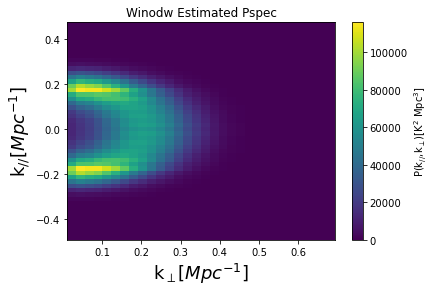

In [55]:
window.bin_p_estimate(pspec.pspec_2D,kmodes_true,kmodes_true)
im = plt.pcolor(pspec.k_perp_bin,kmodes_obs,window.p_estimate_binned, shading = 'auto')#edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Winodw Estimated Pspec')

Text(0.5, 1.0, 'Window Centered on')

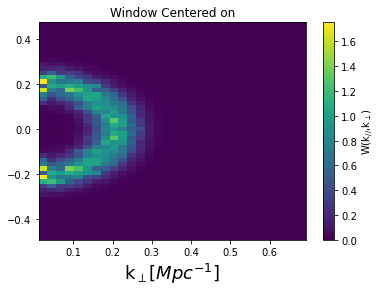

In [70]:

kmodes_true = np.fft.fftshift(pspec.k_par),pspec.k_perp_bin

window.interpolate_pspec_true(pspec.pspec_2D,kmodes_true)



plt.pcolor(kmodes_true[1],kmodes_obs,window.f(kmodes_true[0],kmodes_true[1]),shading='auto')
plt.colorbar(label = 'W(k$_{//}$,k$_{\perp}$)')
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('Window Centered on')

Text(0.5, 1.0, 'True Pspec')

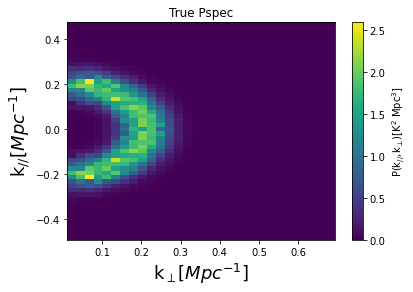

In [30]:
im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, shading = 'auto')#edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)
plt.title('True Pspec')


In [ ]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real((M_hat_x_hat)), aspect = 'auto')
im2 = ax2.imshow(np.reshape(uni_3d.universe,(2500,50)), aspect = 'auto')
im3 = ax3.imshow(np.real(M_hat_x_hat-np.reshape(uni_3d.universe,(2500,50))),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)

# Check 1
M$\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} = x_{true}$

In [169]:
window.compute_2D_FFT()

In [165]:

fft_uni_reshape = np.zeros((2500,50) ,dtype = complex)
for i in range(window.nfreqs):
    fft_uni = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(uni_3d.universe[:,:,i])))
    reshape = fft_uni.reshape((2500,))
    fft_uni_reshape[:,i] = reshape

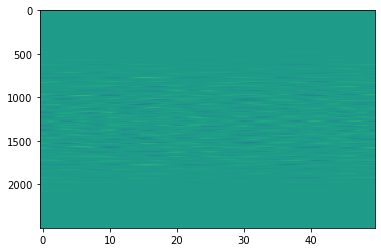

In [166]:
plt.imshow(np.real(fft_uni_reshape), aspect = 'auto')

In [147]:
window.Mbar.shape

(2500, 2500, 50)

In [170]:
M_hat_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.Mbar[:,:,i].dot(fft_uni_reshape[:,i])
    M_hat_x_hat[:,i] = prod


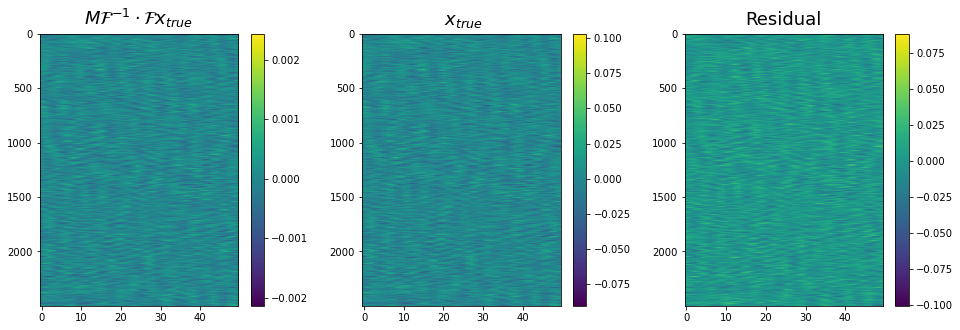

In [171]:
M_hat_x_hat = np.asarray(M_hat_x_hat)
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real((M_hat_x_hat)), aspect = 'auto')
im2 = ax2.imshow(np.reshape(uni_3d.universe,(2500,50)), aspect = 'auto')
im3 = ax3.imshow(np.real(M_hat_x_hat-np.reshape(uni_3d.universe,(2500,50))),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)

# right blobs! wrong amplitude. ok not bad 

# Check 2
$\mathcal{F_\perp}M\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} = \mathcal{F_\perp}x_{obs}$

In [172]:
M_dhat_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.M_tilde[:,:,i].dot(fft_uni_reshape[:,i])
    M_dhat_x_hat[:,i] = prod


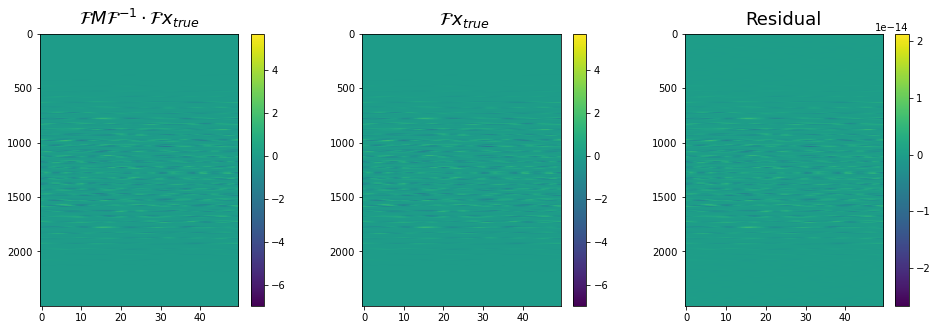

In [176]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$\mathcal{F}M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $\mathcal{F}x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real(M_dhat_x_hat), aspect = 'auto')
im2 = ax2.imshow(np.real(fft_uni_reshape), aspect = 'auto')
im3 = ax3.imshow(np.real(M_dhat_x_hat-fft_uni_reshape),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)



In [185]:
M_dhat_x_hat[1000,20], fft_uni_reshape[1000,20]

((1.2475321429621113e-06+6.077244089781291e-07j),
 (1.2475321428196588e-06+6.077244092590742e-07j))

# Check 3
$\mathcal{F_{\perp,\nu}}x_{true} = \sum_{k_{//}} \mathcal{F_\perp}\mathcal{F_{\nu}}M\mathcal{F_\perp}^{-1}\cdot \mathcal{F_\perp} x_{true} $

window.compute_freq_FFT()

In [26]:
window.compute_k_par()
window.k_perp , kmodes_obs

(array([0.6824705 , 0.66896035, 0.65574016, ..., 0.62846603, 0.64166746,
        0.65517168]),
 array([-0.48258176, -0.46327849, -0.44397522, -0.42467195, -0.40536868,
        -0.38606541, -0.36676214, -0.34745887, -0.3281556 , -0.30885233,
        -0.28954906, -0.27024579, -0.25094252, -0.23163924, -0.21233597,
        -0.1930327 , -0.17372943, -0.15442616, -0.13512289, -0.11581962,
        -0.09651635, -0.07721308, -0.05790981, -0.03860654, -0.01930327,
         0.        ,  0.01930327,  0.03860654,  0.05790981,  0.07721308,
         0.09651635,  0.11581962,  0.13512289,  0.15442616,  0.17372943,
         0.1930327 ,  0.21233597,  0.23163924,  0.25094252,  0.27024579,
         0.28954906,  0.30885233,  0.3281556 ,  0.34745887,  0.36676214,
         0.38606541,  0.40536868,  0.42467195,  0.44397522,  0.46327849]))

In [ ]:
f_x_obs = np.zeros((2500,50))

for i in range(len(kmodes_obs)):
    for j in range(len(window.k_par_minus_prime)):
        
        

In [32]:

fft_uni_3D_reshape = np.zeros((2500,50) ,dtype = complex)
fft_uni_3D = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(uni_3d.universe)))#*pspec.volume_element

for i in range(window.nfreqs):
    reshape = fft_uni_3D[:,:,i].reshape((2500,))
    fft_uni_3D_reshape[:,i] = reshape

In [192]:
#WRONG have to actually do the finding of the k and interpolate fft_uni_reshape

M_that_x_hat = np.zeros((window.Npix,window.nfreqs), dtype= complex)
for i in range(window.nfreqs):
    prod = window.full_Mtilde[:,:,i].dot(fft_uni_reshape[:,i])
    M_that_x_hat[:,i] = prod

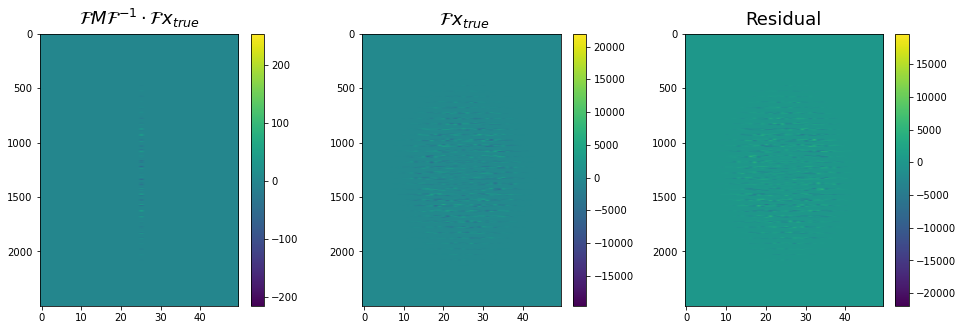

In [193]:
fig3 = plt.figure(figsize = (16,5),constrained_layout=False)
gs = fig3.add_gridspec(1, 3,hspace =0.2, wspace= 0.3)
ax1 = fig3.add_subplot(gs[0, 0])
ax2 = fig3.add_subplot(gs[0, 1])
ax3 = fig3.add_subplot(gs[0,2])

ax1.set_title('$\mathcal{F}M\mathcal{F}^{-1}\cdot \mathcal{F} x_{true}$', fontsize = 18, y = 1.01)
ax2.set_title(' $\mathcal{F}x_{true}$', fontsize = 18, y = 1.01 )
ax3.set_title('Residual', fontsize = 18, y = 1.01)

im1 = ax1.imshow(np.real(M_that_x_hat), aspect = 'auto')
im2 = ax2.imshow(np.real(fft_uni_3D_reshape), aspect = 'auto')
im3 = ax3.imshow(np.real(M_that_x_hat-fft_uni_3D_reshape),aspect = 'auto')

cbar1 = fig3.colorbar(im1, ax=ax1)
cbar2 = fig3.colorbar(im2, ax=ax2)
cbar3 = fig3.colorbar(im3, ax=ax3)